In [1]:
DATA_PATH = "/common/zhangz2lab/honige/data/" # MNIST is in this directory
BASE_HIDDEN_SIZE = 16
AMBER_EPOCHS = 25
MODELS_PER_AMBER_EPOCH = 3
MODEL_EPOCHS = 5

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from amber.architect import IntegerModelVariable, ModelSpace
from amber.architect.controller import RecurrentRLController

# ref: https://github.com/lucidrains/vit-pytorch/blob/main/examples/cats_and_dogs.ipynb
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    try:
        torch.backends.cudnn.deterministic = True
    except:
        print("Failed to set torch.backends.cudnn.deterministic to True")
        pass

seed_everything(42)

Failed to set torch.backends.cudnn.deterministic to True


In [3]:
ds_train = MNIST(root=DATA_PATH, train=True, download=True, transform=transforms.ToTensor())
ds_test = MNIST(root=DATA_PATH, train=False, download=True, transform=transforms.ToTensor())

dl_train = DataLoader(ds_train, batch_size=len(ds_train), shuffle=True, pin_memory=True)
dl_test = DataLoader(ds_test, batch_size=len(ds_test), shuffle=False, pin_memory=True)

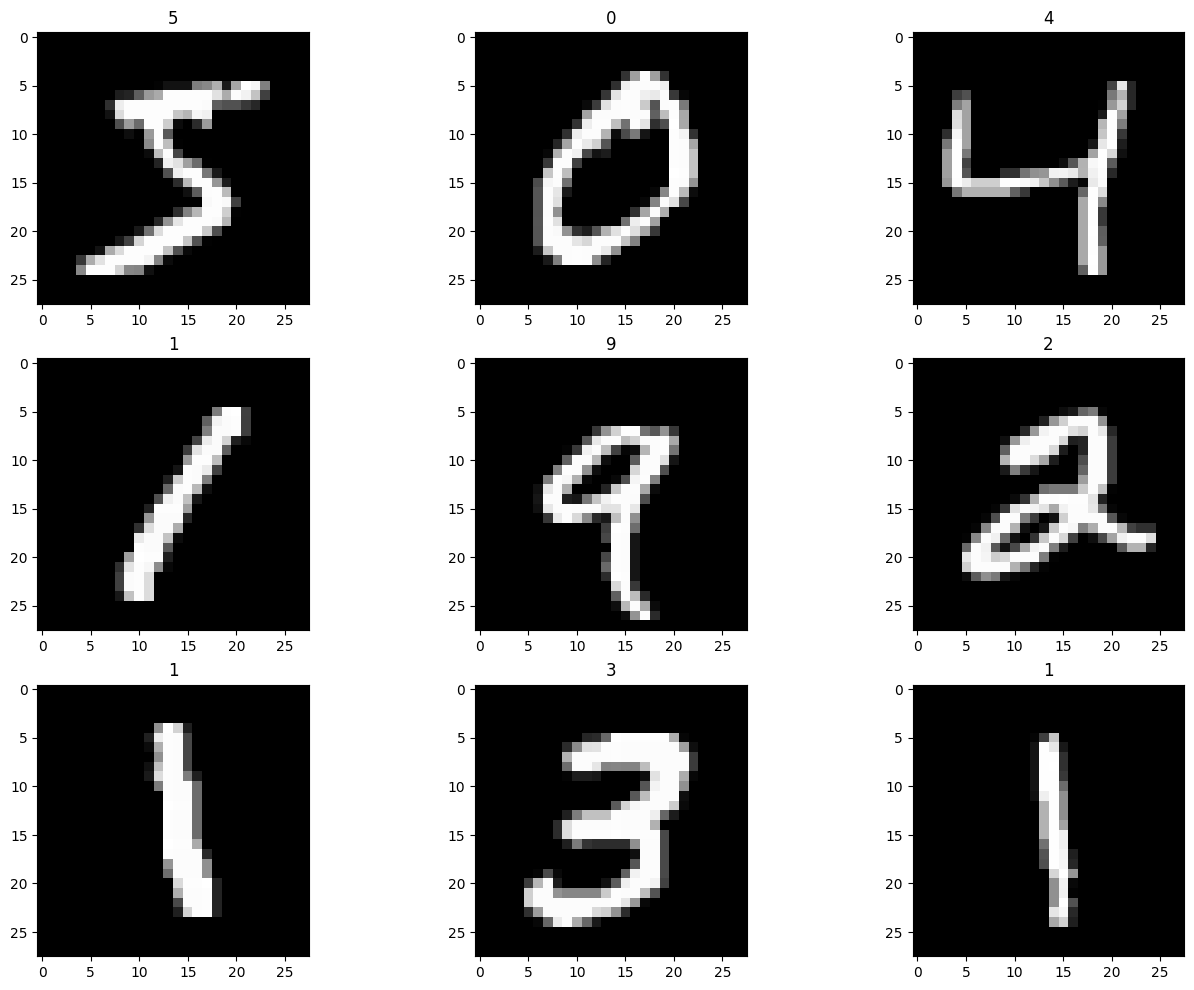

In [4]:
random_idx = np.random.randint(1, len(ds_train), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img, label = ds_train[idx]
    ax.set_title(label)
    ax.imshow(img.reshape(28, 28), cmap="gray")

In [5]:
class LinearActDrop(nn.Module):
    def __init__(self, in_features, out_features, act=nn.LeakyReLU(), p=0.1):
        super().__init__()
        self.out_features = out_features
        self.linear = nn.Linear(in_features, out_features)
        self.act = act
        self.dropout = nn.Dropout(p)
    
    def forward(self, x):
        return self.dropout(self.act(self.linear(x)))

class ResMLP(nn.Module):
    def __init__(self, hidden_size, in_size=28*28, out_size=10, num_hlayers=1, activation=nn.LeakyReLU(), dropout=0.1):
        super().__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.in_layer = LinearActDrop(in_size, hidden_size, act=activation, p=dropout)
        self.layers = nn.ModuleList(
            [LinearActDrop(hidden_size, hidden_size, act=activation, p=dropout) for _ in range(num_hlayers)]
        )
        self.out_layer = LinearActDrop(hidden_size, out_size, act=activation, p=0.)
    
    def forward(self, x):
        x = self.in_layer(x)
        for layer in self.layers:
            x = x + layer(x)
        x = self.out_layer(x)
        return x


class Trainer():
    def __init__(self, model, criterion, optimizer, dl_train, dl_test, device="cuda", verbose=False):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.dl_train = dl_train
        self.dl_test = dl_test
        self.device = device
        self.history = {"train_loss": [], "test_loss": [], "test_acc": []}
    
    def train(self, epochs, verbose=True):
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0
            for x, y in self.dl_train:
                x, y = x.to(self.device), y.to(self.device)
                yhat = self.model(x.flatten(1))
                loss = self.criterion(yhat, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(self.dl_train)
            self.history["train_loss"].append(train_loss)
            test_loss, test_acc = self.test()
            self.history["test_loss"].append(test_loss)
            self.history["test_acc"].append(test_acc)
            if verbose:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    @torch.no_grad()
    def test(self):
        self.model.eval()
        targets = []
        preds = []
        for x, y in self.dl_test:
            x, y = x.to(self.device), y.to(self.device)
            yhat = self.model(x.flatten(1))
            targets.append(y)
            preds.append(yhat)
        targets = torch.cat(targets)
        preds = torch.cat(preds)
        test_loss = self.criterion(preds, targets).item()
        test_acc = (preds.argmax(1) == targets).float().mean().item()
        return test_loss, test_acc

def idx2act(i):
    if i == 0:
        return nn.LeakyReLU()
    elif i == 1:
        return nn.ReLU()
    elif i == 2:
        return nn.SiLU()
    elif i == 3:
        return nn.Tanh()
    else:
        return nn.GELU()

def arc2net(arc, model_space):
    arc_dict = {x:i for i,x in zip(arc, model_space)}
    arc_dict["hidden_size"] = (arc_dict["hidden_size"] + 1) * BASE_HIDDEN_SIZE
    arc_dict["activation"] = idx2act(arc_dict["activation"])
    arc_dict["dropout"] /= 10
    return ResMLP(**arc_dict)

In [6]:
model = ResMLP(32, num_hlayers=1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(model, criterion, optimizer, dl_train, dl_test)
trainer.train(2)
trainer.test()

Epoch 1/2, Train Loss: 2.3164, Test Loss: 2.2880, Test Acc: 0.1185
Epoch 2/2, Train Loss: 2.2896, Test Loss: 2.2618, Test Acc: 0.2386


(2.261765956878662, 0.2386000007390976)

In [7]:
model_space = ModelSpace.from_list([
    IntegerModelVariable(name="hidden_size", min=0, max=9), 
    IntegerModelVariable(name="num_hlayers", min=0, max=8),
    IntegerModelVariable(name="activation", min=0, max=3),
    IntegerModelVariable(name="dropout", min=0, max=9),
])

controller = RecurrentRLController(
            model_space=model_space,
            with_skip_connection=False,
            lstm_size=64,
            lstm_num_layers=1,
            # these hyperparameters are important
            batch_size=3,
            buffer_size=9,
            train_pi_iter=5,
            temperature=2.5,
            rescale_advantage_by_reward=True
)

def train_and_test_arc(arc, model_space):
    model = arc2net(arc, model_space)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    trainer = Trainer(model, criterion, optimizer, dl_train, dl_test, verbose=False)
    trainer.train(MODEL_EPOCHS, verbose=False)
    test_loss, test_acc = trainer.test()
    return model, test_loss, test_acc

def plot_rewards(reward_list):
    fig_reward1, ax_reward1 = plt.subplots()
    ax_reward1.plot(reward_list)
    ax_reward1.set_xlabel('Architecture Iteration')
    ax_reward1.set_ylabel('Reward (Accuracy)')
    ax_reward1.set_title(f'AMBER NAS Full Reward History')
    plt.tight_layout()
    plt.show()

class Timer():
    def __init__(self):
        self.t0 = time.time()
        self.t1 = self.t0

    def __call__(self, end=True):
        if end:
            self.t1 = time.time()
        t_taken = self.t1 - self.t0
        t_hrs, t_mins = divmod(t_taken, 3600)
        t_mins, t_secs = divmod(t_mins, 60)
        return f'{int(t_hrs):02d}:{int(t_mins):02d}:{int(t_secs):02d} (HH:MM:SS)'

NAS trial 0, r_bias=nan, arc=[7 7 3 6], test_loss=1.5247, reward=0.7269
NAS trial 1, r_bias=nan, arc=[8 5 2 3], test_loss=1.8881, reward=0.5629
NAS trial 2, r_bias=nan, arc=[3 6 0 3], test_loss=2.0710, reward=0.4587
NAS trial 3, r_bias=0.5828, arc=[3 2 2 9], test_loss=2.1972, reward=0.6442
NAS trial 4, r_bias=0.5828, arc=[2 6 0 3], test_loss=2.1895, reward=0.3645
NAS trial 5, r_bias=0.5828, arc=[7 1 0 0], test_loss=1.9972, reward=0.5949
NAS trial 6, r_bias=0.5828, arc=[6 2 2 6], test_loss=2.1098, reward=0.6328
NAS trial 7, r_bias=0.5828, arc=[7 1 3 7], test_loss=1.8162, reward=0.7657
NAS trial 8, r_bias=0.5828, arc=[7 7 2 0], test_loss=1.8556, reward=0.5549
NAS trial 9, r_bias=0.5775, arc=[4 1 0 9], test_loss=2.1839, reward=0.4750
NAS trial 10, r_bias=0.5775, arc=[5 8 0 9], test_loss=2.3026, reward=0.1028
NAS trial 11, r_bias=0.5775, arc=[4 4 0 7], test_loss=2.1947, reward=0.4220
NAS trial 12, r_bias=0.5857, arc=[7 0 1 5], test_loss=2.0975, reward=0.5133
NAS trial 13, r_bias=0.5857, ar

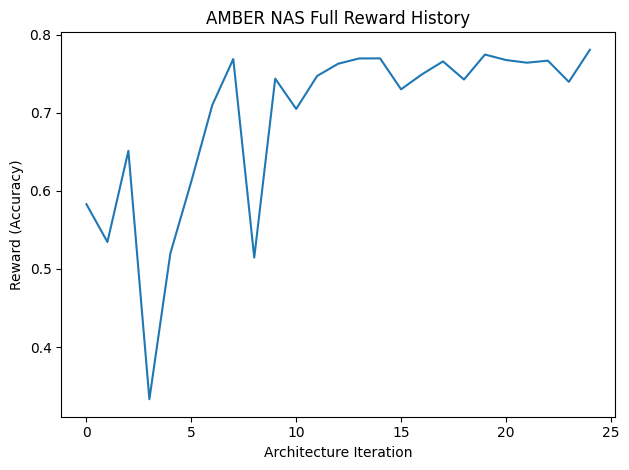

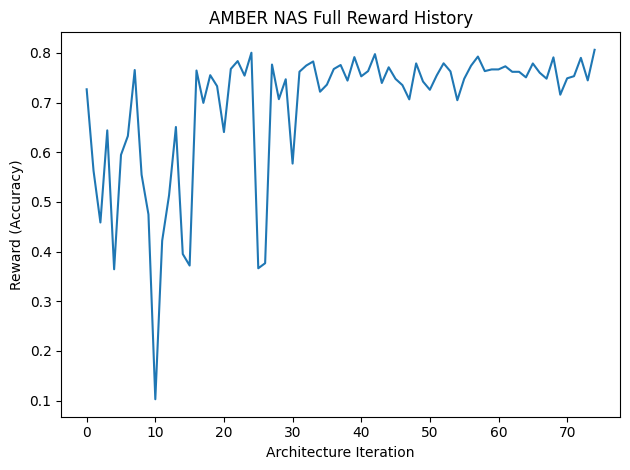

In [8]:
time_amber = Timer()
reward_hist = {'average': [], 'each': {'arc': [], 'reward': []}, 'bad_arcs': []}
for ep in range(AMBER_EPOCHS):
    reward_hist_ep = []
    for i in range(MODELS_PER_AMBER_EPOCH):
        arc, prob = controller.sample()
        model, test_loss, reward = train_and_test_arc(arc, model_space)
        print(f"NAS trial {ep*MODELS_PER_AMBER_EPOCH+i}, r_bias={controller.buffer.r_bias or math.nan:.4f}, arc={arc}, test_loss={test_loss:.4f}, reward={reward:.4f}")
        controller.store(action=arc, prob=prob, reward=reward)
        reward_hist_ep.append(reward)
        reward_hist['each']['arc'].append(arc)
        reward_hist['each']['reward'].append(reward)
        # plot_rewards(reward_hist['each']['reward'])
        del model
        torch.cuda.empty_cache()
    controller.train()        
    torch.cuda.empty_cache()
    reward_hist['average'].append(sum(reward_hist_ep)/len(reward_hist_ep))
    if len(set(tuple(a) for a in reward_hist['each']['arc'][:5])) == 1:
        print(f'AMBER NAS converged to arc={arc} in {ep} epochs')
        break
print(f'AMBER NAS took {time_amber()}')
plot_rewards(reward_hist['average'])
plot_rewards(reward_hist['each']['reward'])